In [7]:
import sys
from tqdm import tqdm 
import numpy as np
from skimage.transform import resize
from numpy.fft import fftn, fftshift
import matplotlib.pyplot as plt
import os
from matplotlib import colors
import matplotlib.pyplot as plt
import random
from multiprocessing import Pool, get_context
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from joblib import Parallel, delayed
from pathlib import Path
import h5py
import torch
import cupy as cp
from cupyx.scipy.signal import convolve2d as conv2



sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))
from src.utils.preprocessing_functions import *
plt.rcParams["image.cmap"] = "jet"

In [8]:
#reduce size of diffraction patterns
red=False #True

#save processed data
save=False

# Setting path
# path = Path("Y:/ptychosaxs")  # /net/micdata/data2/12IDC mounted windows drive
path = Path("/net/micdata/data2/12IDC/ptychosaxs")  # on remote server
print(path)

/net/micdata/data2/12IDC/ptychosaxs


In [9]:
#h5file_data='/net/micdata/data2/12IDC/ptychosaxs/data/diff_sim/ClathII_ptycoSAXSNN_prev_noScanning_Pinhole/sim_ZCB_9_3D_S5065_N1200_steps3_dp256.h5'
#h5file_data='/net/micdata/data2/12IDC/ptychosaxs/data/diff_sim/SC_ptycoSAXSNN_prev_noScanning_Pinhole/sim_ZCB_9_3D_S5065_N1200_steps3_dp256.h5'
#h5file_data='/scratch/LatticeSC_Probe256x256_ZCB_9_3D_/sim_ZCB_9_3D_S5065_N600_steps4_dp256.h5'
#h5file_data='/scratch/LatticeClathII_Probe256x256_ZCB_9_3D_/sim_ZCB_9_3D_S5065_N600_steps4_dp256.h5'
#h5file_data='/scratch/LatticeSC_Probe256x256_ZCB_9_3D__TOMO_TEST/sim_ZCB_9_3D_S5065_N180_steps4_dp256.h5'
h5file_data='/scratch/LatticeSC_Probe256x256_ZCB_9_3D__Noise/sim_ZCB_9_3D_S5065_N600_steps4_dp256.h5'
h5file_data='/scratch/LatticeClathII_Probe256x256_ZCB_9_3D__Noise/sim_ZCB_9_3D_S5065_N600_steps4_dp256.h5'
save_string=h5file_data.split('/')[-2].split('.')[0]+'_'+h5file_data.split('/')[-1].split('.')[0]
print(save_string)

LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256


Loading data from: /scratch/LatticeClathII_Probe256x256_ZCB_9_3D__Noise/sim_ZCB_9_3D_S5065_N600_steps4_dp256.h5
Loaded 9600 diffraction patterns
Pattern shapes - conv_DPs: (9600, 256, 256), ideal_DPs: (9600, 256, 256)


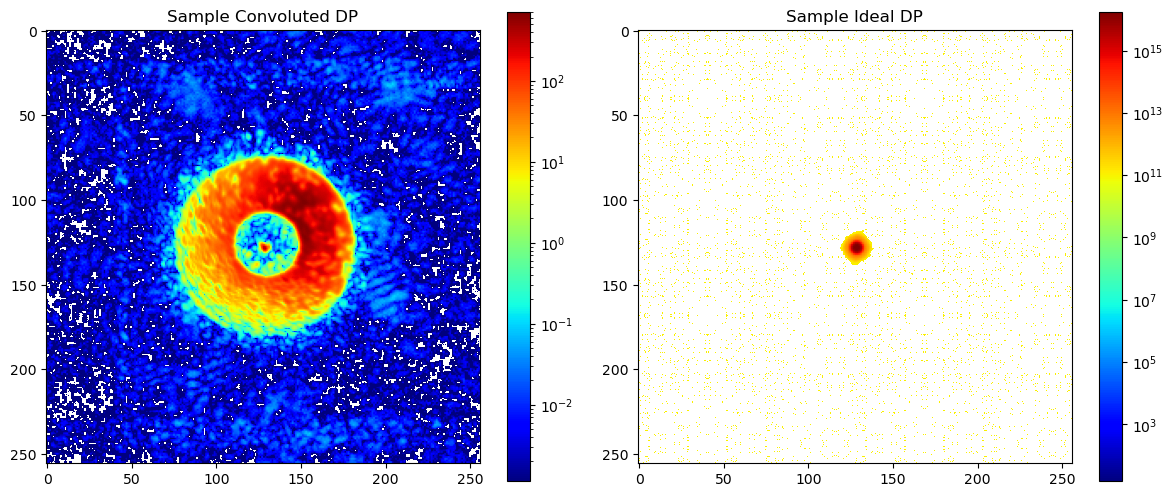

In [10]:
# Load data directly from the HDF5 file
print(f"Loading data from: {h5file_data}")

with h5py.File(h5file_data, "r") as h5f:
    # Load convDP and pinholeDP_raw_FFT as conv and ideal diffraction patterns
    conv_DPs = h5f['convDP'][:]  # Shape: (10800, 256, 256)
    ideal_DPs = h5f['pinholeDP_raw_FFT'][:]  # Shape: (10800, 256, 256)
    
    num_patterns = len(conv_DPs)
    print(f"Loaded {num_patterns} diffraction patterns")
    print(f"Pattern shapes - conv_DPs: {conv_DPs.shape}, ideal_DPs: {ideal_DPs.shape}")

# Create dummy probe array (as before)
probe_DPs = np.ones(conv_DPs.shape)  # dummy array for testing network with a probe

# Display a random pattern to verify the data
ri = np.random.randint(0, len(conv_DPs))
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
im1 = ax[0].imshow(conv_DPs[ri], norm=colors.LogNorm())
ax[0].set_title("Sample Convoluted DP")
plt.colorbar(im1, ax=ax[0])

im2 = ax[1].imshow(ideal_DPs[ri], norm=colors.LogNorm())
ax[1].set_title("Sample Ideal DP")
plt.colorbar(im2, ax=ax[1])

plt.tight_layout()
plt.show()

In [11]:
def create_circular_waxs_mask_min_value(image, radius):
    """
    Create a modified version of the image where the central region is set to the minimum value.
    
    Args:
        image (ndarray): Input image to be masked
        radius (int): Radius of the central circular region to modify
        
    Returns:
        ndarray: Image with central circle set to minimum value
    """
    # Create a copy of the image
    masked_image = image.copy()
    
    # Find minimum value in the image (excluding zeros or NaNs if needed)
    valid_pixels = image[image > 0]  # Adjust if needed
    if len(valid_pixels) > 0:
        min_val = np.min(valid_pixels)
    else:
        min_val = 0
    
    # Create the circular mask
    h, w = image.shape
    y, x = np.indices((h, w))
    center_y, center_x = h // 2, w // 2
    distance_from_center = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
    
    # Set central region to minimum value
    central_region = (distance_from_center <= radius)
    masked_image[central_region] = min_val
    
    return masked_image

# Load your detector mask as before
detector_mask = np.load(os.path.abspath(os.path.join(os.getcwd(), '../../data/mask/mask_ZCB_9_3D.npy')))

# Apply both masks to each image
processed_conv_DPs = []
processed_ideal_DPs = []

# Define the radius for the WAXS mask
radius = 0

waxs_mask=False
# Process each image
for i in tqdm(range(len(conv_DPs))):
    # First apply the detector mask
    masked_conv = apply_mask(conv_DPs[i], detector_mask)
    #masked_ideal = apply_mask(ideal_DPs[i], detector_mask)
    masked_ideal=ideal_DPs[i]
    
    processed_conv_DPs.append(masked_conv)
    processed_ideal_DPs.append(masked_ideal)
    
    if waxs_mask:
        # Then apply the WAXS mask that sets central region to minimum
        processed_conv = create_circular_waxs_mask_min_value(masked_conv, radius)
        processed_ideal = create_circular_waxs_mask_min_value(masked_ideal, radius)
        
        processed_conv_DPs.append(processed_conv)
        processed_ideal_DPs.append(processed_ideal)


# Convert to numpy arrays
processed_conv_DPs = np.array(processed_conv_DPs)
processed_ideal_DPs = np.array(processed_ideal_DPs)


100%|██████████| 9600/9600 [00:01<00:00, 6288.47it/s]


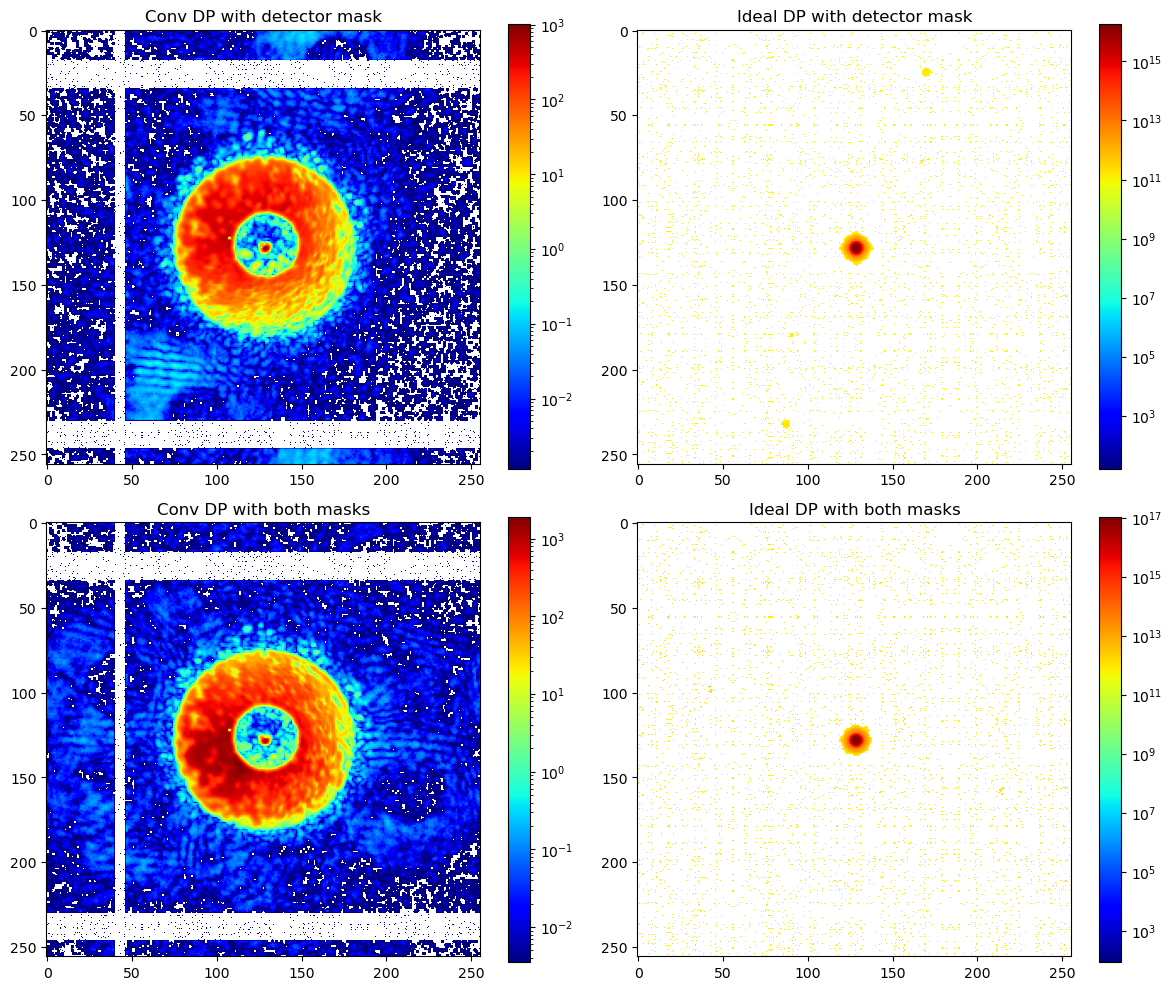

In [12]:
# Visualize the results
ri = np.random.randint(0, len(processed_conv_DPs))
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Original images with detector mask
im1 = ax[0, 0].imshow(masked_conv, cmap="jet", norm=colors.LogNorm())
ax[0, 0].set_title("Conv DP with detector mask")
plt.colorbar(im1, ax=ax[0, 0])

im2 = ax[0, 1].imshow(masked_ideal, cmap="jet", norm=colors.LogNorm())
ax[0, 1].set_title("Ideal DP with detector mask")
plt.colorbar(im2, ax=ax[0, 1])

# Images with both masks
im3 = ax[1, 0].imshow(processed_conv_DPs[ri], cmap="jet", norm=colors.LogNorm())
ax[1, 0].set_title("Conv DP with both masks")
plt.colorbar(im3, ax=ax[1, 0])

im4 = ax[1, 1].imshow(processed_ideal_DPs[ri], cmap="jet", norm=colors.LogNorm())
ax[1, 1].set_title("Ideal DP with both masks")
plt.colorbar(im4, ax=ax[1, 1])

plt.tight_layout()
plt.show()

In [ ]:
#shuffle data correspondingly
shuffle_data=True
if shuffle_data:
    indices = np.arange(processed_conv_DPs.shape[0])
    np.random.shuffle(indices)
    conv_DPs_shuff = processed_conv_DPs[indices]
    ideal_DPs_shuff = processed_ideal_DPs[indices]
    probe_DPs_shuff=probe_DPs[indices]
else:
    conv_DPs_shuff = processed_conv_DPs
    ideal_DPs_shuff = processed_ideal_DPs
    probe_DPs_shuff=probe_DPs

In [14]:
# separate amplitude and phase
# thus network used the amplitude of the intensity patterns
amp_conv = log10_custom(conv_DPs_shuff)
amp_ideal = log10_custom(ideal_DPs_shuff)
amp_probe = np.abs(probe_DPs_shuff)
phase_conv = np.angle(conv_DPs_shuff)
phase_ideal = np.angle(ideal_DPs_shuff)
phase_probe = np.angle(probe_DPs_shuff)

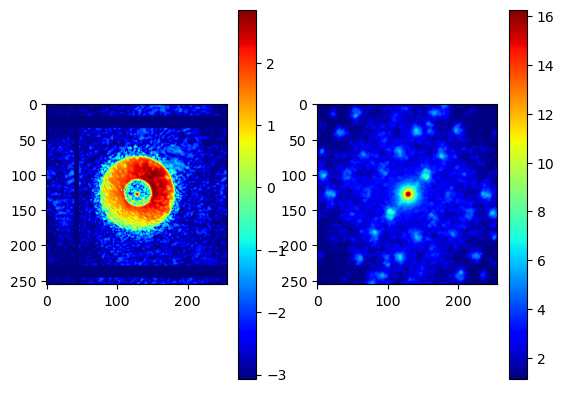

In [15]:
# plot random diffraction pattern
fig,ax=plt.subplots(1,2)
ri=random.randint(0,len(amp_conv))
im1=ax[0].imshow(amp_conv[ri])
im2=ax[1].imshow(amp_ideal[ri])
plt.colorbar(im1)
plt.colorbar(im2)
plt.show()

In [16]:
# resize data
if red:
    print("Resizing...")
    amp_ideal_red=np.asarray([resize(d[:,:],(256,256),preserve_range=True,anti_aliasing=True) for d in tqdm(amp_ideal)])
    amp_conv_red=np.asarray([resize(d[:,:],(256,256),preserve_range=True,anti_aliasing=True) for d in tqdm(amp_conv)])
    amp_probe_red=np.asarray([resize(d[:,:],(256,256),preserve_range=True,anti_aliasing=True) for d in tqdm(amp_probe)])
else:
    print("No resizing...")
    amp_ideal_red=amp_ideal
    amp_conv_red=amp_conv
    amp_probe_red=amp_probe
print(f'maximum in ideal patterns: {np.max(amp_ideal_red[ri])}')
print(f'maximum in conv patterns: {np.max(amp_conv_red[ri])}')    

No resizing...
maximum in ideal patterns: 16.28453826904297
maximum in conv patterns: 2.855264902114868


/tmp/ipykernel_1890224/2302143922.py:16: RuntimeWarning: invalid value encountered in divide
  amp_probe_red=np.asarray([(a-np.min(a))/(np.max(a)-np.min(a)) for a in amp_probe_red])


normalized maximum in ideal/output patterns: 1.0
normalized maximum in conv/input patterns: 1.0


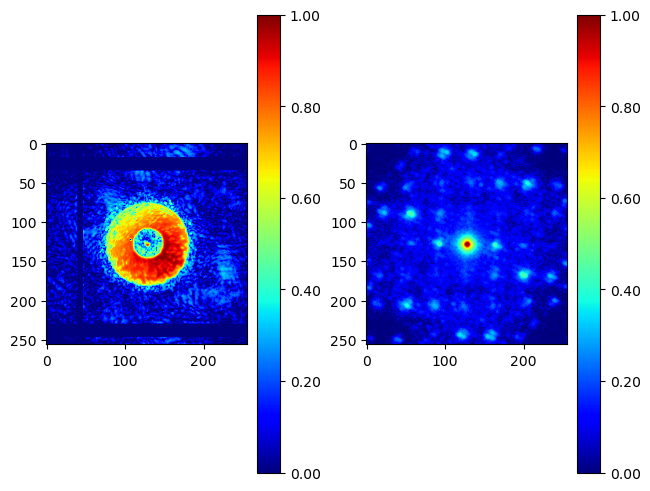

In [17]:
# Scale factors

#NORMALIZE OUTPUT FROM 0 to 1
ideal_scale_factors=np.asarray([(np.max(a)-np.min(a)) for a in amp_ideal_red])
ideal_constants=np.asarray([(np.min(a)) for a in amp_ideal_red])
amp_ideal_red=np.asarray([(a-np.min(a))/(np.max(a)-np.min(a)) for a in amp_ideal_red])

# #NORMALIZE INPUT FROM 0 to 1
conv_scale_factors=np.asarray([(np.max(a)-np.min(a)) for a in amp_conv_red])
conv_constants=np.asarray([(np.min(a)) for a in amp_conv_red])
amp_conv_red=np.asarray([(a-np.min(a))/(np.max(a)-np.min(a)) for a in amp_conv_red])

# #NORMALIZE INPUT FROM 0 to 1
probe_scale_factors=np.asarray([(np.max(a)-np.min(a)) for a in amp_probe_red])
probe_constants=np.asarray([(np.min(a)) for a in amp_probe_red])
amp_probe_red=np.asarray([(a-np.min(a))/(np.max(a)-np.min(a)) for a in amp_probe_red])

print(f'normalized maximum in ideal/output patterns: {np.max(amp_ideal_red[0])}')
print(f'normalized maximum in conv/input patterns: {np.max(amp_conv_red[0])}')

fig,ax=plt.subplots(1,2,layout='constrained')
im1=ax[1].imshow(amp_ideal_red[0])#,norm=colors.LogNorm())
plt.colorbar(im1, ax=ax[1], format='%.2f')
im2=ax[0].imshow(amp_conv_red[0])#,norm=colors.LogNorm())
plt.colorbar(im2, ax=ax[0], format='%.2f')
plt.show()

In [18]:
save=True
if save:
    #np.savez(os.path.abspath(os.path.join(os.getcwd(), f'../../data/processed/preprocessed_dir_July2025_{directory}_{num_patterns}dps.npz')),amp_conv_red=amp_conv_red,amp_ideal_red=amp_ideal_red,amp_probe_red=amp_probe_red)
    np.savez(os.path.abspath(os.path.join(os.getcwd(), f'/scratch/preprocessed_sim_{save_string}.npz')),amp_conv_red=amp_conv_red,amp_ideal_red=amp_ideal_red,amp_probe_red=amp_probe_red)

In [19]:
print(save_string)

LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256


/net/micdata/data2/12IDC/ptychosaxs
LatticeClathII_Probe128x128_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256
Loading data from: /scratch/LatticeClathII_Probe128x128_ZCB_9_3D__Noise/sim_ZCB_9_3D_S5065_N600_steps4_dp256.h5
Loaded 9600 diffraction patterns
Pattern shapes - conv_DPs: (9600, 256, 256), ideal_DPs: (9600, 256, 256)


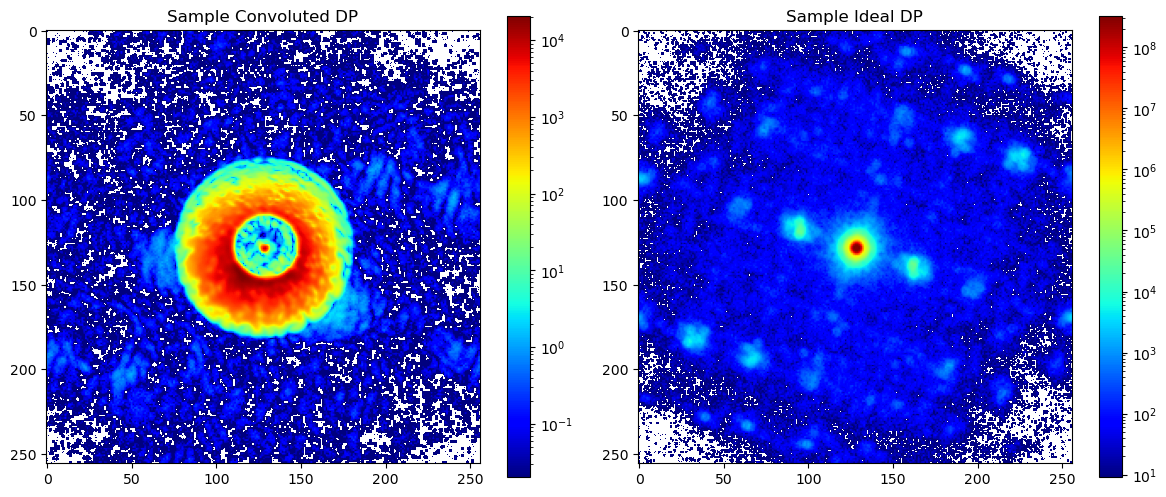

100%|██████████| 9600/9600 [00:01<00:00, 6094.18it/s]


NameError: name 'amp_ideal_red' is not defined

In [ ]:
import sys
from tqdm import tqdm 
import numpy as np
from skimage.transform import resize
from numpy.fft import fftn, fftshift
import matplotlib.pyplot as plt
import os
from matplotlib import colors
import matplotlib.pyplot as plt
import random
from multiprocessing import Pool, get_context
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from joblib import Parallel, delayed
from pathlib import Path
import h5py
import torch
import cupy as cp
from cupyx.scipy.signal import convolve2d as conv2
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))
from src.utils.preprocessing_functions import *
plt.rcParams["image.cmap"] = "jet"

#save processed data
save=True

#shuffle data
shuffle_data=True

#resize data
red=False #Tr

# Setting path
# path = Path("Y:/ptychosaxs")  # /net/micdata/data2/12IDC mounted windows drive
path = Path("/net/micdata/data2/12IDC/ptychosaxs")  # on remote server
print(path)

lattice_list=['ClathII','SC',]
noise_list=['Noise','noNoise']
probe_size_list=[128,256]
#numDPs_list=[9600]


for lattice in lattice_list:
    for noise in noise_list:
        for probe_size in probe_size_list:
            h5file_data=f'/scratch/Lattice{lattice}_Probe{probe_size}x{probe_size}_ZCB_9_3D__{noise}/sim_ZCB_9_3D_S5065_N600_steps4_dp256.h5'
            save_string=h5file_data.split('/')[-2].split('.')[0]+'_'+h5file_data.split('/')[-1].split('.')[0]
            print(save_string)
            
            # Load data directly from the HDF5 file
            print(f"Loading data from: {h5file_data}")

            with h5py.File(h5file_data, "r") as h5f:
                # Load convDP and pinholeDP_raw_FFT as conv and ideal diffraction patterns
                conv_DPs = h5f['convDP'][:]  # Shape: (10800, 256, 256)
                ideal_DPs = h5f['pinholeDP_raw_FFT'][:]  # Shape: (10800, 256, 256)
                
                num_patterns = len(conv_DPs)
                print(f"Loaded {num_patterns} diffraction patterns")
                print(f"Pattern shapes - conv_DPs: {conv_DPs.shape}, ideal_DPs: {ideal_DPs.shape}")

            # Create dummy probe array (as before)
            probe_DPs = np.ones(conv_DPs.shape)  # dummy array for testing network with a probe

            # Display a random pattern to verify the data
            ri = np.random.randint(0, len(conv_DPs))
            fig, ax = plt.subplots(1, 2, figsize=(12, 5))
            im1 = ax[0].imshow(conv_DPs[ri], norm=colors.LogNorm())
            ax[0].set_title("Sample Convoluted DP")
            plt.colorbar(im1, ax=ax[0])

            im2 = ax[1].imshow(ideal_DPs[ri], norm=colors.LogNorm())
            ax[1].set_title("Sample Ideal DP")
            plt.colorbar(im2, ax=ax[1])

            plt.tight_layout()
            plt.show()
            
            # Load your detector mask as before
            detector_mask = np.load(os.path.abspath(os.path.join(os.getcwd(), '../../data/mask/mask_ZCB_9_3D.npy')))

            # Apply both masks to each image
            processed_conv_DPs = []
            processed_ideal_DPs = []

            # Process each image
            for i in tqdm(range(len(conv_DPs))):
                # First apply the detector mask
                masked_conv = apply_mask(conv_DPs[i], detector_mask)
                #masked_ideal = apply_mask(ideal_DPs[i], detector_mask)
                masked_ideal=ideal_DPs[i]
                
                processed_conv_DPs.append(masked_conv)
                processed_ideal_DPs.append(masked_ideal)
            # Convert to numpy arrays
            processed_conv_DPs = np.array(processed_conv_DPs)
            processed_ideal_DPs = np.array(processed_ideal_DPs)
            
            #shuffle data correspondingly
            if shuffle_data:
                indices = np.arange(processed_conv_DPs.shape[0])
                np.random.shuffle(indices)
                conv_DPs_shuff = processed_conv_DPs[indices]
                ideal_DPs_shuff = processed_ideal_DPs[indices]
                probe_DPs_shuff=probe_DPs[indices]
            else:
                conv_DPs_shuff = processed_conv_DPs
                ideal_DPs_shuff = processed_ideal_DPs
                probe_DPs_shuff=probe_DPs
            
            # separate amplitude and phase
            # thus network used the amplitude of the intensity patterns
            amp_conv = log10_custom(conv_DPs_shuff)
            amp_ideal = log10_custom(ideal_DPs_shuff)
            amp_probe = np.abs(probe_DPs_shuff)
            phase_conv = np.angle(conv_DPs_shuff)
            phase_ideal = np.angle(ideal_DPs_shuff)
            phase_probe = np.angle(probe_DPs_shuff)
            
            # resize data
            if red:
                print("Resizing...")
                amp_ideal_red=np.asarray([resize(d[:,:],(256,256),preserve_range=True,anti_aliasing=True) for d in tqdm(amp_ideal)])
                amp_conv_red=np.asarray([resize(d[:,:],(256,256),preserve_range=True,anti_aliasing=True) for d in tqdm(amp_conv)])
                amp_probe_red=np.asarray([resize(d[:,:],(256,256),preserve_range=True,anti_aliasing=True) for d in tqdm(amp_probe)])
            else:
                print("No resizing...")
                amp_ideal_red=amp_ideal
                amp_conv_red=amp_conv
                amp_probe_red=amp_probe
            
            ri=random.randint(0,len(amp_conv))
            print(f'maximum in ideal patterns: {np.max(amp_ideal_red[ri])}')
            print(f'maximum in conv patterns: {np.max(amp_conv_red[ri])}')
            
            # Scale factors
            #NORMALIZE OUTPUT FROM 0 to 1
            ideal_scale_factors=np.asarray([(np.max(a)-np.min(a)) for a in amp_ideal_red])
            ideal_constants=np.asarray([(np.min(a)) for a in amp_ideal_red])
            amp_ideal_red=np.asarray([(a-np.min(a))/(np.max(a)-np.min(a)) for a in amp_ideal_red])

            # #NORMALIZE INPUT FROM 0 to 1
            conv_scale_factors=np.asarray([(np.max(a)-np.min(a)) for a in amp_conv_red])
            conv_constants=np.asarray([(np.min(a)) for a in amp_conv_red])
            amp_conv_red=np.asarray([(a-np.min(a))/(np.max(a)-np.min(a)) for a in amp_conv_red])

            # #NORMALIZE INPUT FROM 0 to 1
            probe_scale_factors=np.asarray([(np.max(a)-np.min(a)) for a in amp_probe_red])
            probe_constants=np.asarray([(np.min(a)) for a in amp_probe_red])
            amp_probe_red=np.asarray([(a-np.min(a))/(np.max(a)-np.min(a)) for a in amp_probe_red])

            print(f'normalized maximum in ideal/output patterns: {np.max(amp_ideal_red[0])}')
            print(f'normalized maximum in conv/input patterns: {np.max(amp_conv_red[0])}')

            fig,ax=plt.subplots(1,2,layout='constrained')
            im1=ax[1].imshow(amp_ideal_red[0])#,norm=colors.LogNorm())
            plt.colorbar(im1, ax=ax[1], format='%.2f')
            im2=ax[0].imshow(amp_conv_red[0])#,norm=colors.LogNorm())
            plt.colorbar(im2, ax=ax[0], format='%.2f')
            plt.show()

            if save:
                np.savez(os.path.abspath(os.path.join(os.getcwd(), f'/scratch/preprocessed_sim_{save_string}.npz')),amp_conv_red=amp_conv_red,amp_ideal_red=amp_ideal_red,amp_probe_red=amp_probe_red)
                print('save string:', save_string)
                #print(f'saved preprocessed data to {os.path.abspath(os.path.join(os.getcwd(), f'/scratch/preprocessed_sim_{save_string}.npz'))}')